In [15]:
from itertools import cycle

import numpy as np
#from sklearn.datasets import fetch_mldata
#from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.signal import convolve2d, convolve
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
# from torchvision.datasets import MNIST
# from torchvision import transforms
from IPython.display import clear_output
from typing import Tuple
from tqdm import *
%matplotlib inline

In [3]:
def corrected_f1_score(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    scores = []
    for predict, true in zip(y_pred, y_true):
        pred_size = (predict >= predict[-1]).sum()
        predict = np.argsort(predict)[::-1][:pred_size]

        size = max(pred_size, (true > -1).sum())
        if size > len(predict):
            predict = np.pad(predict, (0, size - len(predict)), constant_values=-1)

        score = f1_score(true[:size], predict, average="macro")
        scores.append(score)
    return sum(scores) / len(scores)

In [4]:
import matplotlib.pyplot as plt
import note_seq
import bokeh
import librosa.display

from src.features.build_features import detokenize
from src.entities.audio_params import AudioParams
from src.entities.dataset_params import DatasetParams
from src.data.make_dataset import WavMidiDataset, AudioDataset


SAMPLE_RATE = 44100
FRAME_LENGTH = 4096
OVERLAPPING = 8


audio_params = AudioParams(
    sample_rate=SAMPLE_RATE,
    frame_length=FRAME_LENGTH,
    n_mels=512,
    fmin=8,
    fmax=12500,
    window="taylor"
)
train_params = DatasetParams(
    root_path="/mnt/d/Datasets/maestro-v3.0.0/",
    metadata="maestro-v3.0.0.csv",
    years_list=[2017],
    split="train",
    audio_params=audio_params,
    feature_size=3,
    overlapping=OVERLAPPING,
)
test_params = DatasetParams(
    root_path="/mnt/d/Datasets/maestro-v3.0.0/",
    metadata="maestro-v3.0.0.csv",
    years_list=[2017],
    split="test",
    audio_params=audio_params,
    feature_size=3,
    overlapping=OVERLAPPING,
)

gpu = True

device = torch.device("cuda" if torch.cuda.is_available() and gpu else "cpu")
device

/home/ilya20/docomets/MusicTranscription/.venv/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


device(type='cuda')

In [5]:
train_ds = WavMidiDataset(train_params)
test_ds = WavMidiDataset(test_params)

In [6]:
len(train_ds), len(test_ds)

(106, 18)

In [7]:
# frames, notes, times = train_ds[37]
# train_audio_ds = AudioDataset(frames, notes)
# train_loader = DataLoader(train_audio_ds, 1000)

# frames, notes, times = test_ds[7]
# test_audio_ds = AudioDataset(frames, notes)
# test_loader = DataLoader(test_audio_ds, 1000)

# train_loader = DataLoader(train_ds, 1)
# test_loader = DataLoader(test_ds, 1)

In [8]:
# loss = nn.MultiLabelMarginLoss()
# x = torch.FloatTensor([[0.1, 0.9, 0.1, 1]])
# # for target y, only consider labels 3 and 0, not after label -1
# y = torch.LongTensor([[1, 3, -1, -1]])
# # 0.25 * ((1-(0.1-0.2)) + (1-(0.1-0.4)) + (1-(0.8-0.2)) + (1-(0.8-0.4)))
# loss(x, y)

In [9]:
# frames, notes, _ = train_ds[10]
# audio_ds = AudioDataset(frames, notes)
# audio_loader = DataLoader(audio_ds, 15, )

In [10]:
# for X, y in audio_loader:
#     pitch, vel = y
#     print(pitch.shape)
#     break

In [11]:
def train(network, epochs: int, learning_rate=1e-4, batch_size=100):
    loss_nll = nn.NLLLoss()
    loss_multi = nn.MultiLabelMarginLoss()
    # loss_mse = nn.MSELoss()
    
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    
    try:
        for epoch in range(epochs):
            test_cycle = cycle(test_ds)
            for i, item in enumerate(zip(train_ds, test_cycle)):
                # train
                losses_pitch = []
                losses_vel = []
                accuracies_pitch = []
                accuracies_vel = []

                frames, notes, _ = item[0]
                train_audio = AudioDataset(frames, notes)
                train_audio_loader = DataLoader(train_audio, batch_size)
                audio_iter = tqdm(train_audio_loader)
                for X, y in audio_iter:
                    X = X.to(device)

                    pitch, vel = y
                    pitch = pitch.to(device)
                    vel = vel.to(device)

                    network.zero_grad()
                    pred_pitch, pred_vel = network.forward(X)

                    loss_batch_pitch = loss_multi(pred_pitch, pitch)
                    losses_pitch.append(loss_batch_pitch.item())
                    loss_batch_pitch.backward()
                    optimizer.step()

                    audio_iter.set_description("TRAIN: Epoch: %04d, Audio: %04d/%04d, Iter Loss: %.4f"  %(epoch, i, len(train_ds), loss_batch_pitch))
                    accuracies_pitch.append(corrected_f1_score(pred_pitch.cpu().detach().numpy(), pitch.cpu().detach().numpy()))

                train_loss_epochs.append(np.mean(losses_pitch))
                train_accuracy_epochs.append(np.mean(accuracies_pitch))

                # test
                losses = []
                accuracies = []

                frames, notes, _ = item[1]
                test_audio = AudioDataset(frames, notes)
                test_audio_loader = DataLoader(test_audio, batch_size)
                audio_iter = tqdm(test_audio_loader)
                for X, y in audio_iter:
                    X = X.to(device)
                    
                    pitch, vel = y
                    pitch = pitch.to(device)
                    vel = vel.to(device)

                    pred_pitch, pred_vel = network.forward(X)

                    loss_batch = loss_multi(pred_pitch, pitch)
                    losses.append(loss_batch.item())

                    audio_iter.set_description("TEST: Epoch: %04d, Audio: %04d/%04d, Iter Loss: %.4f"  %(epoch, i, len(test_ds), loss_batch))
                    accuracies.append(corrected_f1_score(pred_pitch.cpu().detach().numpy(), pitch.cpu().detach().numpy()))

                test_loss_epochs.append(np.mean(losses))
                test_accuracy_epochs.append(np.mean(accuracies))
                
                # output
                clear_output(True)
                print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.show()
    except KeyboardInterrupt:
        pass

In [12]:
def train_single(network, epochs: int, learning_rate=1e-4, batch_size=100):
    loss_nll = nn.NLLLoss()
    loss_multi = nn.MultiLabelMarginLoss()
    # loss_mse = nn.MSELoss()
    
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    
    frames, notes, _ = train_ds[10]
    train_audio = AudioDataset(frames, notes)
    
    frames, notes, _ = test_ds[0]
    test_audio = AudioDataset(frames, notes)

    try:
        for epoch in range(epochs):
            # train
            losses_pitch = []
            losses_vel = []
            accuracies_pitch = []
            accuracies_vel = []
            
            train_audio_loader = DataLoader(train_audio, batch_size)
            audio_iter = tqdm(train_audio_loader)
            for X, y in audio_iter:
                X = X.to(device)
                
                pitch, vel = y
                pitch = pitch.to(device)
                vel = vel.to(device)

                network.zero_grad()

                pred_pitch, pred_vel = network.forward(X)

                loss_batch_pitch = loss_multi(pred_pitch, pitch)
                losses_pitch.append(loss_batch_pitch.item())
                loss_batch_pitch.backward()

                audio_iter.set_description("Epoch: %04d, Iter Loss: %.4f"  %(epoch, loss_batch_pitch))

                optimizer.step()
                accuracies_pitch.append(corrected_f1_score(pred_pitch.cpu().detach().numpy(), pitch.cpu().detach().numpy()))

            train_loss_epochs.append(np.mean(losses_pitch))
            train_accuracy_epochs.append(np.mean(accuracies_pitch))

            # test
            losses = []
            accuracies = []

            test_audio_loader = DataLoader(test_audio, batch_size)
            audio_iter = tqdm(test_audio_loader)
            for X, y in audio_iter:
                X = X.to(device)

                pitch, vel = y
                pitch = pitch.to(device)
                vel = vel.to(device)

                pred_pitch, pred_vel = network.forward(X)

                loss_batch = loss_multi(pred_pitch, pitch)
                losses.append(loss_batch.item())

                audio_iter.set_description("Epoch: %04d, Iter Loss: %.4f"  %(epoch, loss_batch))

                accuracies.append(corrected_f1_score(pred_pitch.cpu().detach().numpy(), pitch.cpu().detach().numpy()))

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            
            # output
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

In [13]:
class DummyNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),
    
            nn.Conv2d(64, 64, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        self.maxpool1 = nn.MaxPool2d((4, 1))

        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        self.conv_layer5 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        self.maxpool2 = nn.MaxPool2d((1, 3))
        self.flatten = nn.Flatten()

        self.linear_layer = nn.Sequential(
            nn.Linear(16384, 8000),
            nn.Dropout(0.3),
            nn.Tanh(),
            nn.Linear(8000, 129),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x) + x
        x = self.maxpool1(x)

        x = self.conv_layer3(x)
        x = self.conv_layer4(x) + x
        x = self.conv_layer5(x) + x
        x = self.maxpool2(x)

        x = self.flatten(x)
        x = self.linear_layer(x)
        return x, 90

Epoch 0... (Train/Test) NLL: 0.105/0.242	Accuracy: 0.092/0.090


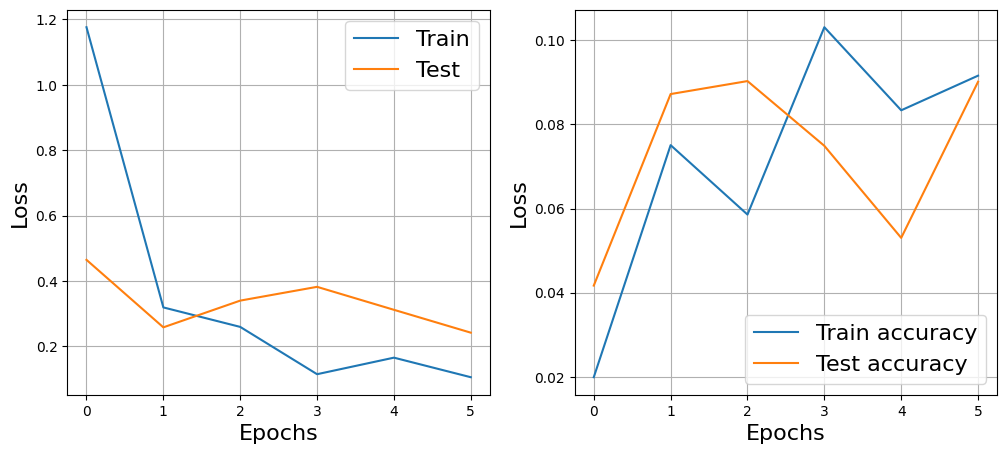

In [16]:
net = DummyNet().to(device)
train(net, 20, 1e-4, 100)

In [ ]:
torch.save(net.state_dict(), "../models/model.ptx")

In [10]:
net = DummyNet()
net.load_state_dict(torch.load("../models/model_resnet.ptx"))

<All keys matched successfully>

In [11]:
frames, notes, times = train_ds[12]
midi_filename, _ = train_ds._data.iloc[12]
ns = note_seq.midi_file_to_note_sequence(train_ds._root_path + midi_filename)

In [12]:
len(notes)

5621

In [13]:
def decode_predict(pitches, vels):
    notes = []
    pitches = pitches.detach()
    softmax = nn.Softmax(dim=1)
    pitches = softmax(pitches).numpy()
    for pitch in pitches:
        pred_size = (pitch >= pitch[128]).sum()
        pred_size = min(pred_size, 5)
        pitch = np.argsort(pitch)[::-1][:pred_size]
        vel = np.full_like(pitch, vels)

        notes.append((pitch, vel))
    return notes

In [14]:
audio_ds = AudioDataset(frames, notes)
audio_loader = DataLoader(audio_ds, 100)

pred_notes = []

audio_iter = tqdm(audio_loader)
for X, y in audio_iter:
    pitch, vel = y

    pred_pitch, pred_vel = net(X)
    pred_notes.extend(decode_predict(pred_pitch, pred_vel))

100%|██████████| 57/57 [00:40<00:00,  1.39it/s]


In [ ]:
import bokeh

fig = note_seq.plot_sequence(ns, False)
fig_proc = note_seq.plot_sequence(detokenize(pred_notes, times, train_ds._frame_time), False)

fig.height = 500
fig_proc.height = 500
fig.width = 1500
fig_proc.width = 1500

bokeh.plotting.output_notebook()
bokeh.plotting.show(fig)
bokeh.plotting.show(fig_proc)

In [ ]:
note_seq.play_sequence(ns)

In [ ]:
pred_ns = detokenize(pred_notes, times, train_ds._frame_time)
note_seq.play_sequence(pred_ns)

### Conv2D

In [5]:
#constants
image_size = (28, 28)
conv1 = 32
conv2 = 64

# conv_nn
class ConvTwoD(nn.Module):
    def __init__(self, image_size: Tuple[int, int],
        conv1=conv1, conv2=conv2
    ):
        super(ConvTwoD, self).__init__()
        self.conv_layers1 = nn.Sequential(
            nn.Conv2d(1, conv1, kernel_size=(5,5), stride=(1,1)),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )
        
        self.conv_layers2 = nn.Sequential(
            nn.Conv2d(conv1, conv2, kernel_size=(3,3), stride=(2,2)),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=(2,2))
        )
        
        self.linear_velocity = nn.Sequential(
            nn.Linear(
                conv2 * image_size[0]//2 * image_size[1]//2,
                128
            ),
            nn.LogSoftmax(dim=1)
        )

        self.linear_pitch = nn.Sequential(
            nn.Linear(
                conv2 * image_size[0]//2 * image_size[1]//2,
                128
            ),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
#         print("======")
#         print(x.shape)
        x = self.conv_layers1(x)
#         print(x.shape)
        x = self.conv_layers2(x)
#         print(x.shape)
        x = x.view(x.size(0), -1)
#         print(x.shape)
        pitch = self.linear_pitch(x)
        velocity = self.linear_velocity(x)
        
        return pitch, velocity

### Conv1D

In [6]:
#constants
image_size = 28
conv1 = 32
conv2 = 64

# conv_nn
class ConvOneD(nn.Module):
    def __init__(self, image_size: Tuple[int, int],
        conv1=conv1, conv2=conv2
    ):
        super(ConvOneD, self).__init__()
        self.conv_layers1 = nn.Sequential(
            # nn.Conv2d(1, conv1, kernel_size=(5,5), stride=(1,1)),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_layers2 = nn.Sequential(
            # nn.Conv2d(conv1, conv2, kernel_size=(3,3), stride=(2,2)),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.linear_velocity = nn.Sequential(
            nn.Linear(
                conv2 * image_size,
                128
            ),
            nn.LogSoftmax(dim=1)
        )

        self.linear_pitch = nn.Sequential(
            nn.Linear(
                conv2 * image_size,
                128
            ),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
#         print("======")
#         print(x.shape)
        x = convolve(x, 5, mode="same")
        x = self.conv_layers1(x)
#         print(x.shape)
        x = convolve(x, 5, mode="same")
        # x = self.conv_layers2(x)
#         print(x.shape)
        x = x.view(x.size(0), -1)
#         print(x.shape)
        pitch = self.linear_pitch(x)
        velocity = self.linear_velocity(x)
        
        return pitch, velocity

In [ ]:
network1 = Conv(image_size=image_size)
train(network1, 5)